In [4]:
import numpy as np
import matplotlib.pyplot as plt
from Metrics import get_percolation, get_num_clusters
import seaborn as sns
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
from scipy.spatial import cKDTree
import networkx as nx
from matplotlib import image
from tqdm import tqdm

In [2]:
# Getting data

start_folder= "data/vitro_gradves_grid/"
conc_lst    = np.linspace(0.5, 0.99, 15)
data_lst    = []

for conc in conc_lst:
    data_lst.append(np.load(start_folder + f"conc_{conc:.2f}/data.npy", allow_pickle=True))
    

In [39]:
perc_lst_lst        = []
tot_cell_lst_lst    = []
pol_cell_lst_lst    = []
pct_2cell_lst_lst   = []
num_clust_lst_lst   = []

for i,conc in enumerate(tqdm(conc_lst)):
    p_mask_lst, x_lst, _, _ = data_lst[i]
    tot_cell_lst    = []
    pct_2cell_lst   = []
    perc_lst        = []
    pol_cell_lst    = []
    num_clust_lst   = []

    for timestep in range(len(x_lst)-20):
        x       = x_lst[timestep + 20]
        pp_mask  = p_mask_lst[timestep + 20]
        polar_p_mask = pp_mask.copy()
        polar_p_mask[polar_p_mask == 2] = 1

        tot_cell_lst.append(len(x))
        pct_2cell_lst.append(np.sum(pp_mask == 2) / len(pp_mask) )
        perc    = get_percolation(x=x, p_mask = polar_p_mask)
        perc_lst.append(perc)
        pol_cell_lst.append(np.sum(polar_p_mask == 1 ))
        num_clust_lst.append(get_num_clusters(x, polar_p_mask, threshold=50))

    tot_cell_lst_lst.append(tot_cell_lst)
    pct_2cell_lst_lst.append(pct_2cell_lst)
    perc_lst_lst.append(perc_lst)
    pol_cell_lst_lst.append(pol_cell_lst)
    num_clust_lst_lst.append(num_clust_lst)
 

100%|██████████| 15/15 [01:56<00:00,  7.79s/it]


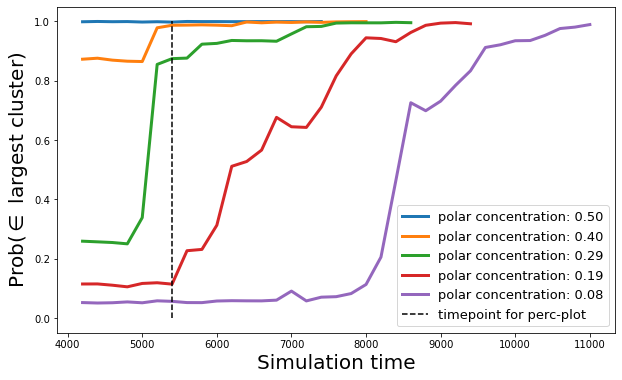

In [178]:
fig, ax = plt.subplots(figsize=(10,6))
for i,perc_lst in enumerate(perc_lst_lst[::3]):
    ax.plot(np.arange(21,len(perc_lst)+21)*1000*0.2,perc_lst, label=f'polar concentration: {1-conc_lst[i*3]:.2f}', linewidth=3)

ax.vlines(5400, 0, 1, color='black', ls='--', label='timepoint for perc-plot')
ax.set_xlabel('Simulation time', fontsize=20)
ax.set_ylabel('Prob($\in$ largest cluster)', fontsize=20)
plt.legend(fontsize=13)
plt.show()

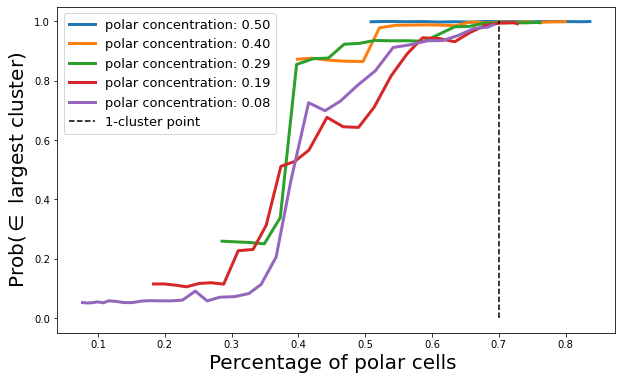

In [104]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(len(perc_lst_lst)):
    if i % 3 == 0:
        ax.plot(np.array(pol_cell_lst_lst[i])/np.array(tot_cell_lst_lst[i]), perc_lst_lst[i], label=f'polar concentration: {1-conc_lst[i]:.2f}', linewidth=3)

ax.vlines(0.7, 0, 1, color='black', ls='--', label='1-cluster point')
ax.set_xlabel('Percentage of polar cells ', fontsize=20)
ax.set_ylabel('Prob($\in$ largest cluster)', fontsize=20)
plt.legend(fontsize=13)
plt.show()

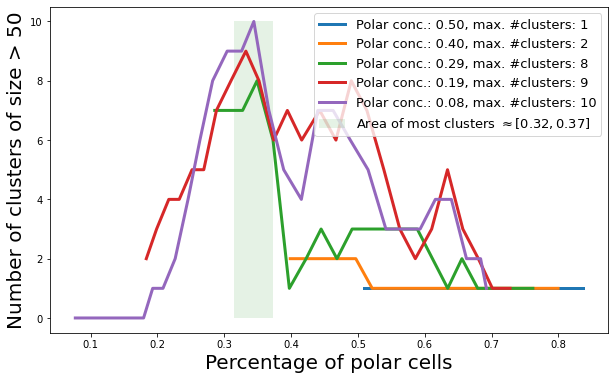

In [109]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(len(perc_lst_lst)):
    if i % 3 == 0:
        ax.plot(np.array(pol_cell_lst_lst[i])/np.array(tot_cell_lst_lst[i]), num_clust_lst_lst[i], label=f'Polar conc.: {1-conc_lst[i]:.2f}, max. #clusters: {max(num_clust_lst_lst[i])}', linewidth=3)


ax.axhspan(0, 10, 0.33, 0.4, facecolor='green', alpha=0.1, label='Area of most clusters $\\approx [0.32,0.37]$')
ax.set_xlabel('Percentage of polar cells', fontsize=20)
ax.set_ylabel('Number of clusters of size > 50', fontsize=20)
plt.legend(fontsize=13)
plt.show()

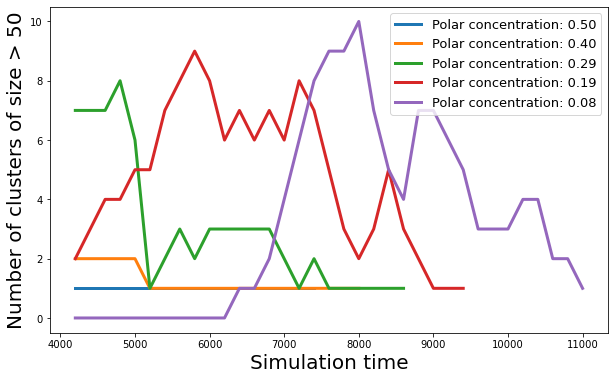

In [105]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(len(perc_lst_lst)):
    if i % 3 == 0:
        ax.plot(np.arange(21,len(perc_lst_lst[i])+21)*1000*0.2, num_clust_lst_lst[i], label=f'Polar concentration: {1-conc_lst[i]:.2f}', linewidth=3)

ax.set_xlabel('Simulation time', fontsize=20)
ax.set_ylabel('Number of clusters of size > 50', fontsize=20)
plt.legend(fontsize=13)
plt.show()

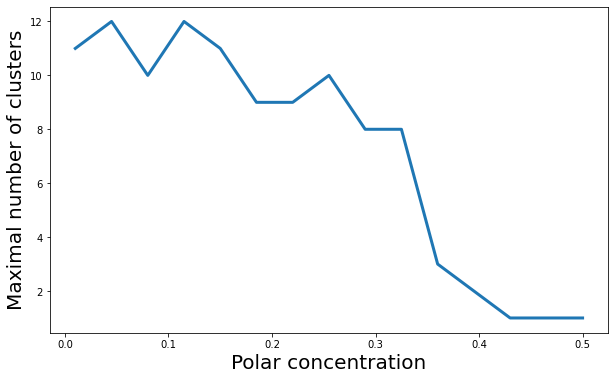

In [133]:
fig, ax = plt.subplots(figsize=(10,6))

max_num_clust_lst = []

for i in range(len(perc_lst_lst)):
    max_num_clust_lst.append(max(num_clust_lst_lst[i]))

ax.plot(1-conc_lst, max_num_clust_lst, linewidth=3)
ax.set_xlabel('Polar concentration', fontsize=20)
ax.set_ylabel('Maximal number of clusters', fontsize=20)
plt.show()

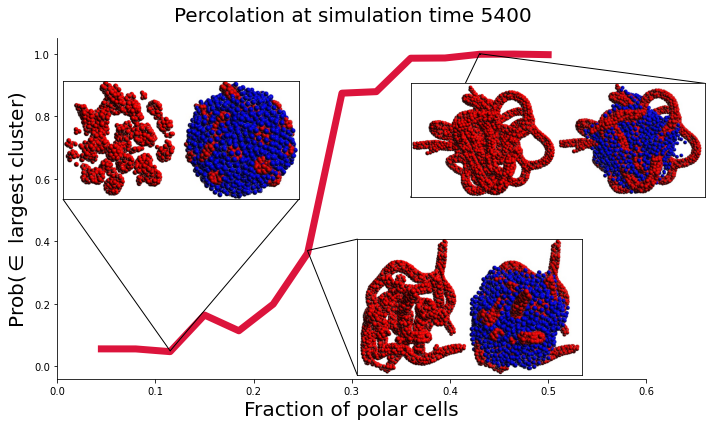

In [239]:
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

conc_lst    = np.linspace(0.5, 0.99, 15)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,6), sharey=True, tight_layout=True)


conc01_img = image.imread("plots/gradves_conc_0.11_all.png")
conc02_img = image.imread("plots/gradves_conc_0.26_all.png")
conc04_img = image.imread("plots/gradves_conc_0.43_all.png")


axins0 = ax.inset_axes([0.01, 0.5, 0.4, 0.4])
axins0.imshow(conc01_img)
axins0.set_xticks([])
axins0.set_yticks([])
for spine in axins0.spines.values():
    spine.set_edgecolor('black')
    spine.set_linestyle('-')
ax.indicate_inset([0.115, 0.05, 0.0001, 0.001], axins0, edgecolor="black", alpha=1)

axins1 = ax.inset_axes([0.5, 0.01, 0.4, 0.4])
axins1.imshow(conc02_img)
axins1.set_xticks([])
axins1.set_yticks([])
for spine in axins1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linestyle('-')
ax.indicate_inset([0.255, 0.37, 0.0001, 0.001], axins1, edgecolor="black", alpha=1, capstyle='projecting')

axins2 = ax.inset_axes([0.6, 0.45, 0.5, 0.5])
axins2.imshow(conc04_img)
axins2.set_xticks([])
axins2.set_yticks([])
for spine in axins2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linestyle('-')
ax.indicate_inset([0.43, 1, 0.0001, 0.001], axins2, edgecolor="black", alpha=1, capstyle='projecting')


ax.set_xlabel('Fraction of polar cells', fontsize=20)
ax.set_ylabel(f'Prob($\in$ largest cluster)', fontsize=20)
ax.set_xlim(0.00,0.6)

perc_plot_perc_lst = []

for i in range(len(perc_lst_lst)):
    perc_plot_perc_lst.append(perc_lst_lst[i][6])
ax.plot((1-conc_lst)[:-1], perc_plot_perc_lst[:-1], linestyle='-', alpha=1, linewidth=7, color='crimson');

fig.suptitle('Percolation at simulation time 5400', fontsize=20)

sns.despine()

In [179]:
arr = np.arange(21,len(perc_lst)+21)*1000*0.2
arr[6]

5400.0

In [2]:
start_folder = "data/percolation_plot/"
# perc_lst = []
# conc_lst = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

for conc in conc_lst:
    data = np.load(start_folder + f"conc_{conc}/data.npy", allow_pickle=True)
    p_mask = data[0][25]
    x      = data[1][25]

    perc = get_percolation(x, p_mask)

    perc_lst.append(perc)

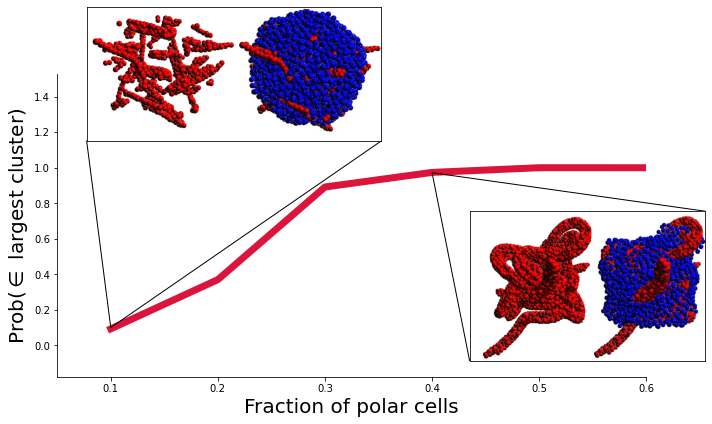

In [151]:
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

conc_lst = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,6), sharey=True, tight_layout=True)



conc01_img = image.imread("plots/perc_plots_new_conc_0.9_tot.png")
conc04_img = image.imread("plots/perc_plots_new_conc_0.6_tot.png")
# conc09_img = image.imread("plots/conc0.09.png")


axins0 = ax.inset_axes([0.05, 0.55, 0.5,0.9])
axins0.imshow(conc01_img)
axins0.set_xticks([])
axins0.set_yticks([])
for spine in axins0.spines.values():
    spine.set_edgecolor('black')
    spine.set_linestyle('-')
ax.indicate_inset([0.1, 0.1, 0.0001, 0.001], axins0, edgecolor="black", alpha=1)

axins1 = ax.inset_axes([0.7, -0.1, 0.4, 0.8])
axins1.imshow(conc04_img)
axins1.set_xticks([])
axins1.set_yticks([])
for spine in axins1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linestyle('-')
ax.indicate_inset([0.4, 0.97, 0.0001, 0.001], axins1, edgecolor="black", alpha=1, capstyle='projecting')


# imagebox = OffsetImage(conc04_img, zoom=0.4)
# ab = AnnotationBbox(imagebox, (0.4,0.5), frameon=False)
# ax.add_artist(ab)

# imagebox = OffsetImage(conc01_img, zoom=0.4)
# ab = AnnotationBbox(imagebox, (0.15,0.70), frameon=False)
# ax.add_artist(ab)


ax.set_xlabel('Fraction of polar cells', fontsize=20)
ax.set_ylabel(f'Prob($\in$ largest cluster)', fontsize=20)
ax.set_xlim(0.05,0.6)
# ax.set_lim(0.00,1)

ax.plot(1-conc_lst[3:], perc_lst[3:], linestyle='-', alpha=1, linewidth=7, color='crimson');
# imagebox = OffsetImage(conc25_img, zoom=0.21)
# ab = AnnotationBbox(imagebox, (0.242,0.89), frameon=False)
# ax.add_artist(ab)


sns.despine()

In [38]:
size_lst = [2_000, 4_000, 8_000]
conc_lst = [0.6, 0.7 ,0.8, 0.9]

start_folder = "data/vitro_grid_maybe_fixed/"

perc_arr = np.zeros((3, 4))
clust_arr = np.zeros((3, 4))

for i,size in enumerate(size_lst):
    for j,conc in enumerate(conc_lst):
        data = np.load(start_folder + f"size{size}_conc{conc}/data.npy", allow_pickle=True)
        p_mask = data[0][-1]
        x      = data[1][-1]

        perc = get_percolation(x, p_mask)

        p_mask = data[0][1]
        x      = data[1][1]

        num_clusters = get_num_clusters(x, p_mask, threshold=5)

        clust_arr[i,j]  = num_clusters
        perc_arr[i,j]   = perc

Text(0.5, 1.0, 'Prob($\\in$ largest cluster)')

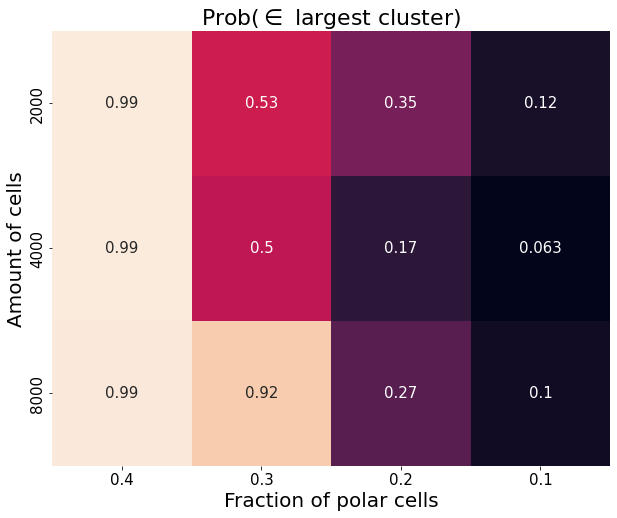

In [39]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.heatmap(perc_arr, annot=True, xticklabels=np.round(1.-np.array(conc_lst),1), yticklabels=size_lst, annot_kws={"fontsize": 15 }, cbar=False)
ax.set_xlabel("Fraction of polar cells", fontsize=20)
ax.set_xticklabels(np.round(1.-np.array(conc_lst),1), fontsize=15)

ax.set_ylabel("Amount of cells", fontsize=20)
ax.set_yticklabels(size_lst, fontsize=15)

ax.set_title('Prob($\in$ largest cluster)', fontsize=22)

Text(0.5, 1.0, '#clusters w. size > 5')

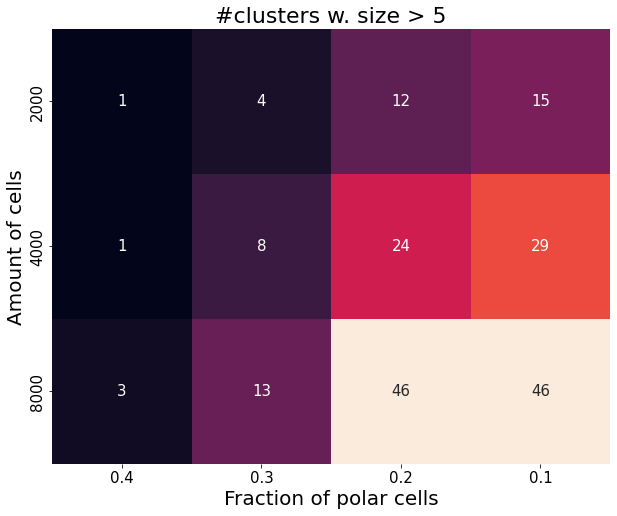

In [41]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.heatmap(clust_arr, annot=True, xticklabels=np.round(1.-np.array(conc_lst),1), yticklabels=size_lst, annot_kws={"fontsize": 15 }, cbar=False)
ax.set_xlabel("Fraction of polar cells", fontsize=20)
ax.set_xticklabels(np.round(1.-np.array(conc_lst),1), fontsize=15)

ax.set_ylabel("Amount of cells", fontsize=20)
ax.set_yticklabels(size_lst, fontsize=15)

ax.set_title('#clusters w. size > 5', fontsize=22)